In [45]:
import tensorflow as tf
from keras import layers, Model
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tensorflow.python.framework.ops import enable_eager_execution
enable_eager_execution()

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.reset_memory_stats(gpu, True)

tf.config.run_functions_eagerly(True)

In [31]:
my_data = pd.read_csv('HarrisCounty/JanFeb.csv')
ds_w = []
ds_e = []
for c in my_data.columns:
    if 'weekday' in c:
        ds_w.append(my_data[c].values.reshape([6, 4]))
    else:
        ds_e.append(my_data[c].values.reshape([6, 4]))

ds_w = np.divide(ds_w, 1.2 * np.max(ds_w))
ds_e = np.divide(ds_e, 1.2 * np.max(ds_e))
ds_w = tf.data.Dataset.from_tensor_slices(ds_w)
ds_e = tf.data.Dataset.from_tensor_slices(ds_e)

In [32]:
ds_w = ds_w.cache()
ds_w = ds_w.shuffle(1000)
ds_w = ds_w.batch(6)
ds_w = ds_w.prefetch(64)

In [6]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

## Generator

In [33]:
def build_generator():
    model = Sequential()
    # Takes a random values, reshapes it to 8*6
    model.add(Dense(3*2*6, input_dim=6))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((3, 2, 6)))

    model.add(UpSampling2D())
    model.add(Conv2D(6, 5, padding='same'))
    model.add(LeakyReLU(0.2))

    '''model.add(UpSampling2D())
    model.add(Conv2D(6, 5, padding='same'))
    model.add(LeakyReLU(0.2))'''

    model.add(Conv2D(6, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(6, 4, padding='same'))
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))
    # model.add(Reshape((6, 24, 1)))
    return model

In [35]:
generator = build_generator()
generator.summary()
# series = generator.predict(np.random.randn(4, 6, 1))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 36)                252       
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 36)                0         
                                                                 
 reshape_2 (Reshape)         (None, 3, 2, 6)           0         
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 6, 4, 6)           0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 6, 4, 6)           906       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 6, 4, 6)           0         
                                                      

## Discriminator

In [36]:
def build_discriminator():
    model = Sequential()

    model.add(Conv2D(32, 2, input_shape=(6, 4, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(64, 2))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Conv2D(128, 2))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # 1: fake series, 0: real series

    return model

In [37]:
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 5, 3, 32)          160       
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 5, 3, 32)          0         
                                                                 
 dropout_4 (Dropout)         (None, 5, 3, 32)          0         
                                                                 
 conv2d_16 (Conv2D)          (None, 4, 2, 64)          8256      
                                                                 
 leaky_re_lu_16 (LeakyReLU)  (None, 4, 2, 64)          0         
                                                                 
 dropout_5 (Dropout)         (None, 4, 2, 64)          0         
                                                                 
 conv2d_17 (Conv2D)          (None, 3, 1, 128)        

In [12]:
# Single prediction needs np.expand_dims(series[0], 0)
# discriminator.predict(np.expand_dims(series[0], 0))

1/1 [==============================] - 0s 69ms/step


array([[0.49589217]], dtype=float32)

In [38]:
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy

In [51]:
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)  # Does not learn too fast
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [52]:
# importing the base model class to subclass our training step
from keras.models import Model

In [53]:
class LoadGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # pass through args and kwargs to base class
        super().__init__(*args, **kwargs)
        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compilee(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        real_series = batch
        fake_series = self.generator(tf.random.normal((6, 6, 1)), training=False)

        # train the discriminator
        with tf.GradientTape() as d_tape:
            # pass the real and fake images
            yhat_real = self.discriminator(real_series, training=True)
            yhat_fake = self.discriminator(fake_series, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # create labels for real and fake series
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)


            # pass through and add some noise to the outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = 0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # calculate the loss
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # apply backpropagation
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Generator training
        with tf.GradientTape() as g_tape:
            # generate same new images
            gen_series = self.generator(tf.random.normal((6, 6, 1)), training=True)

            # create the predicted labels
            predicted_labels = self.discriminator(gen_series, training=False)

            # calculate loss
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # apply backpropagation
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}


In [54]:
loadgan = LoadGAN(generator, discriminator)

In [55]:
loadgan.compilee(g_opt, d_opt, g_loss, d_loss)

#### Call Back

In [42]:
import os
from keras.preprocessing.image import array_to_img
from keras.callbacks import Callback


In [56]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=6):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vector = tf.random.uniform((self.num_img, self.latent_dim, 1))
        generated_series = self.model.generator(random_latent_vector)
        generated_series *= 300
        generated_series.numpy()
        for i in range(self.num_img):
            serie = array_to_img(generated_series[i])
            serie.save(os.path.join('series', f'generated_img_{epoch}_{i}.png'))

#### Train

In [57]:
hist = loadgan.fit(ds_w, epochs=10, callbacks=[ModelMonitor()])

Epoch 1/10
8/8 [==============================] - 1s 112ms/step - d_loss: 0.6728 - g_loss: 0.7149
Epoch 2/10
8/8 [==============================] - 1s 112ms/step - d_loss: 0.6653 - g_loss: 0.7152
Epoch 3/10
8/8 [==============================] - 1s 112ms/step - d_loss: 0.6778 - g_loss: 0.7146
Epoch 4/10
8/8 [==============================] - 1s 111ms/step - d_loss: 0.6614 - g_loss: 0.7145
Epoch 5/10
8/8 [==============================] - 1s 111ms/step - d_loss: 0.6639 - g_loss: 0.7151
Epoch 6/10
8/8 [==============================] - 1s 107ms/step - d_loss: 0.6689 - g_loss: 0.7127
Epoch 7/10
8/8 [==============================] - 1s 114ms/step - d_loss: 0.6737 - g_loss: 0.7116
Epoch 8/10
8/8 [==============================] - 1s 120ms/step - d_loss: 0.6697 - g_loss: 0.7092
Epoch 9/10
8/8 [==============================] - 1s 117ms/step - d_loss: 0.6697 - g_loss: 0.7104
Epoch 10/10
8/8 [==============================] - 1s 132ms/step - d_loss: 0.6772 - g_loss: 0.7069


1/1 [==============================] - 0s 42ms/step


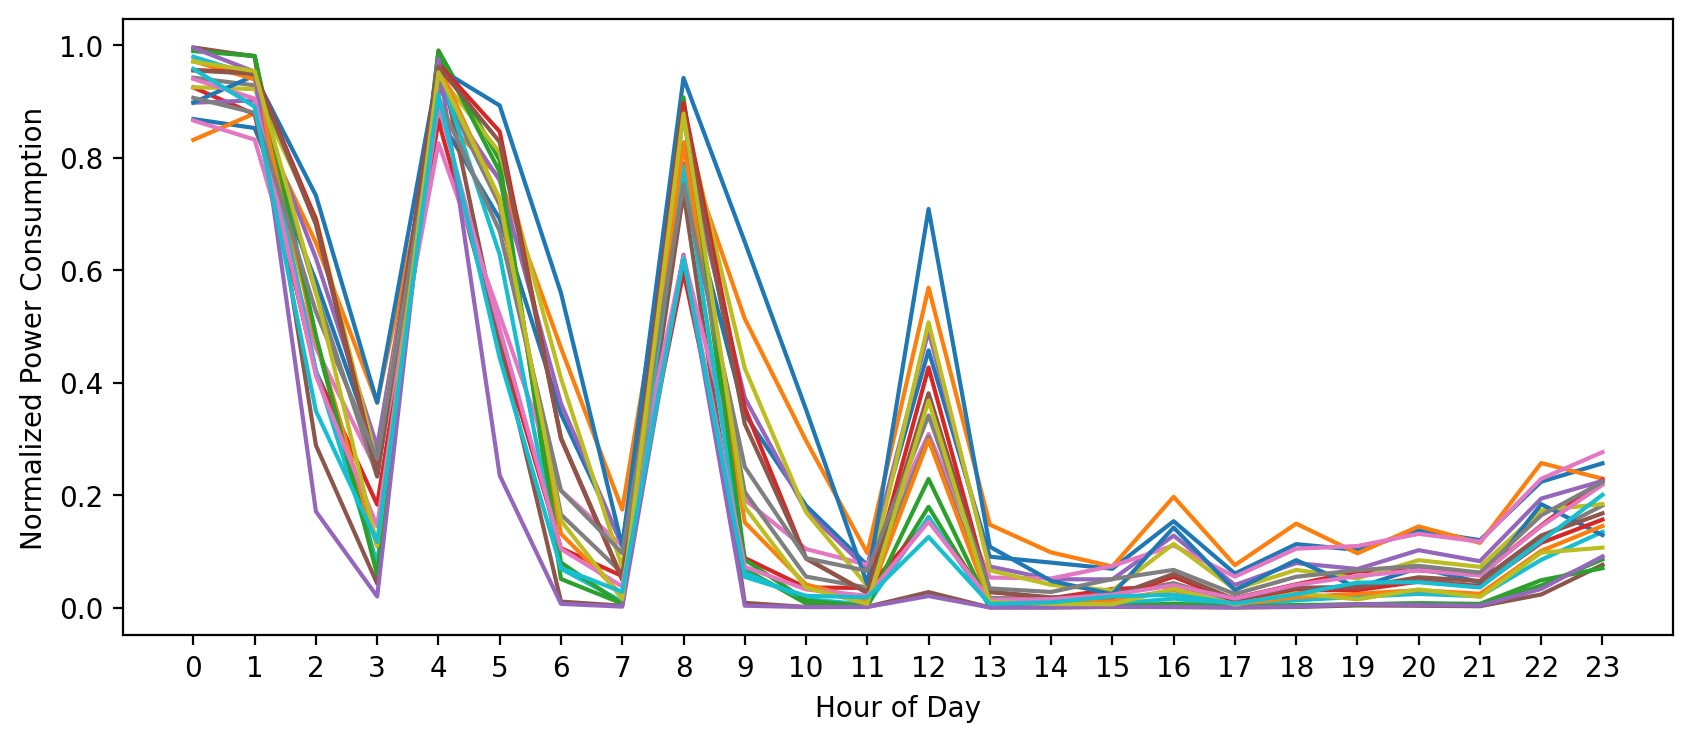

In [59]:
series = generator.predict(tf.random.normal((20, 6, 1)))
fig = plt.figure(figsize=(10, 4), dpi=200)
for s in series:
    plt.plot(range(24), s.reshape([24]))
plt.xlabel('Hour of Day')
plt.ylabel('Normalized Power Consumption')
plt.xticks(range(24))
plt.show()

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')